In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import time

In [2]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 70
g_lr = 0.0001
d_lr = 0.0004
beta1 = 0.5
ngpu=1

clamp_num=0.01# WGAN clip gradient

In [7]:
# Define a transform to normalize the input images between -1 and 1
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)), 
    transforms.ToTensor(),                      
    transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) 
])
dataset = dset.CIFAR10(
    root='./data',  # Use a local directory you can access
    train=True,
    download=True,
    transform=transform
)
   
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,  
    shuffle=True,          
    num_workers=2           
)


Files already downloaded and verified


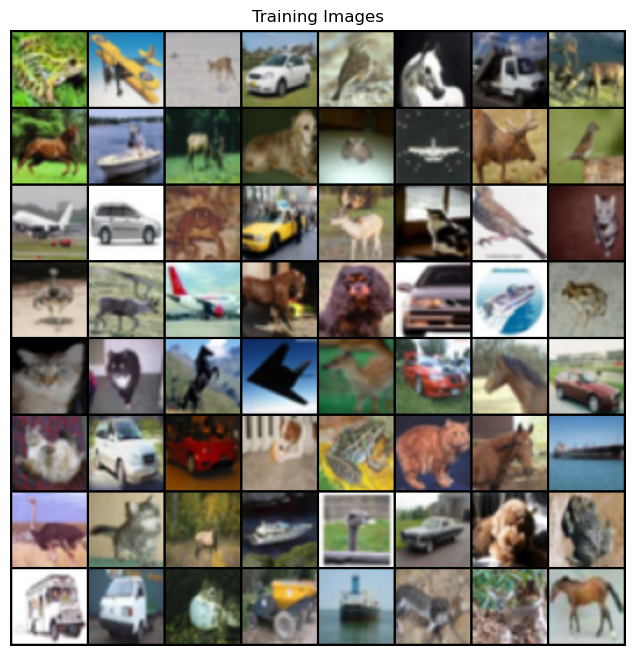

In [8]:
# Determine the device for computation
if torch.cuda.is_available() and ngpu > 0:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
real_batch = next(iter(dataloader))
images_to_display = real_batch[0][:64].to(device)  # Select the first 64 images
grid = vutils.make_grid(images_to_display, padding=2, normalize=True).cpu()

plt.figure(figsize=(8, 8))
plt.title("Training Images")
plt.axis("off")
plt.imshow(np.transpose(grid, (1, 2, 0)))


In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.initial = nn.Sequential(
            # Initial layer: Input is Z
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True)
        )

        self.middle_layers = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.initial(input)
        x = self.middle_layers(x)
        x = self.final(x)
        return x


In [10]:
# Custom weights initialization for netG and netD
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        # Initialize convolutional layers with a normal distribution
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
    elif isinstance(m, nn.BatchNorm2d):
        # Initialize batch normalization layers
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.constant_(m.bias, 0)


In [11]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (initial): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (middle_layers): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (final): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stri

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.layers = nn.ModuleList([
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        ])

    def forward(self, input):
        x = input
        for layer in self.layers:
            x = layer(x)
        return x


In [14]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [15]:
criterion = nn.BCELoss()
real_label = 0.9 
fake_label = 0.1  
optimizerD = optim.RMSprop(params=netD.parameters(), lr=d_lr)
optimizerG = optim.RMSprop(params=netG.parameters(), lr=g_lr)


In [16]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    DEFAULT_BLOCK_INDEX = 3  

    BLOCK_INDEX_BY_DIM = {
        64: 0,   
        192: 1,  
        768: 2,  
        2048: 3  
    }

    def __init__(self, output_blocks=None, resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.output_blocks = sorted(output_blocks or [self.DEFAULT_BLOCK_INDEX])
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.last_needed_block = max(self.output_blocks)
        assert self.last_needed_block <= 3, "Last possible output block index is 3"
        inception = models.inception_v3(pretrained=True)

        self.blocks = nn.ModuleList()
        self._build_blocks(inception)
        for param in self.parameters():
            param.requires_grad = requires_grad

    def _build_blocks(self, inception):
        """Helper to build the feature blocks of InceptionV3."""
        # Block 0: Input to first max pooling
        self.blocks.append(nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ))
        if self.last_needed_block >= 1:
            self.blocks.append(nn.Sequential(
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ))
        if self.last_needed_block >= 2:
            self.blocks.append(nn.Sequential(
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e
            ))
        if self.last_needed_block >= 3:
            self.blocks.append(nn.Sequential(
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ))

    def forward(self, inp):
        """Forward pass through the model to get feature maps."""
        x = inp
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = x * 2 - 1  # Scale to range (-1, 1)

        outp = []  
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break

        return outp
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3(output_blocks=[block_idx])
model = model.cuda()


/home/bsowmya/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bsowmya/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    
    model.eval()
    activations = np.zeros((len(images), dims))
    images = images.cuda() if cuda else images
    with torch.no_grad():
        predictions = model(images)[0]
        if predictions.shape[2] != 1 or predictions.shape[3] != 1:
            predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))
        activations = predictions.cpu().numpy().reshape(predictions.size(0), -1)
    mu = activations.mean(axis=0)
    sigma = np.cov(activations, rowvar=False)

    return mu, sigma


In [18]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)
    if mu1.shape != mu2.shape:
        raise ValueError("Mean vectors have different dimensions")
    if sigma1.shape != sigma2.shape:
        raise ValueError("Covariance matrices have different dimensions")
    diff = mu1 - mu2
    try:
        covmean = linalg.sqrtm(sigma1 @ sigma2, disp=False)[0]
        if not np.isfinite(covmean).all():
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))[0]
    except Exception as e:
        raise ValueError(f"Error computing sqrtm: {e}")
    if np.iscomplexobj(covmean):
        covmean = np.real(covmean)
    tr_covmean = np.trace(covmean)
    fid_value = (
        np.dot(diff, diff) +
        np.trace(sigma1) +
        np.trace(sigma2) -
        2 * tr_covmean
    )

    return fid_value


In [19]:
def calculate_fretchet(images_real, images_fake, model):
    """
    Calculate the Frechet Inception Distance (FID) between two sets of images.
    """
    stats_real = calculate_activation_statistics(images_real, model, cuda=True)
    stats_fake = calculate_activation_statistics(images_fake, model, cuda=True)
    
    mu_1, std_1 = stats_real
    mu_2, std_2 = stats_fake
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    
    return fid_value


In [20]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))

Generator Parameters: 3576704
Discriminator Parameters: 2765568


Starting Training Loop...
[5/70]	Loss_D: -0.2216	Loss_G: 0.4001	Fretchet_Distance: 182.2204


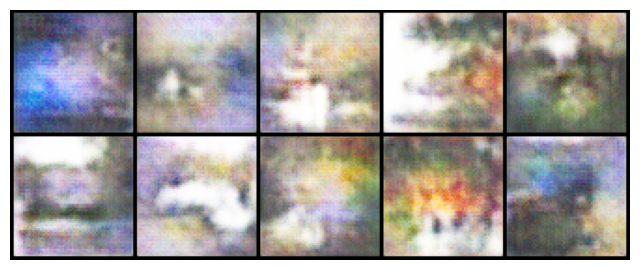

[10/70]	Loss_D: -0.0767	Loss_G: 0.3685	Fretchet_Distance: 185.5902


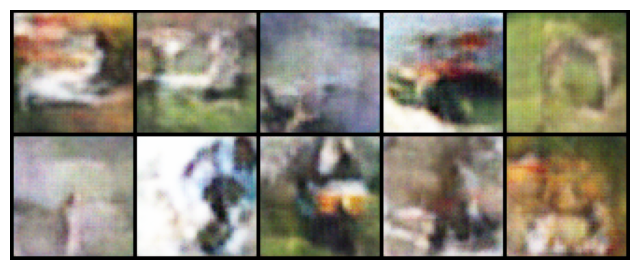

[15/70]	Loss_D: -0.0542	Loss_G: -0.1997	Fretchet_Distance: 179.2686


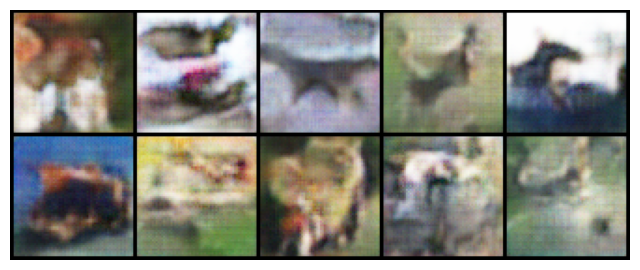

[20/70]	Loss_D: 0.0115	Loss_G: -0.3283	Fretchet_Distance: 195.6410


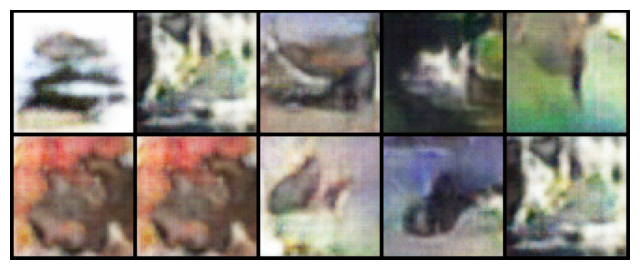

[25/70]	Loss_D: -0.0039	Loss_G: 0.0221	Fretchet_Distance: 189.6371


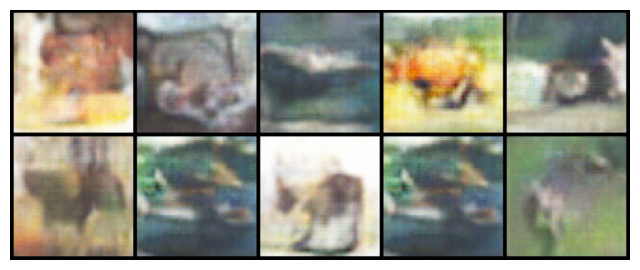

[30/70]	Loss_D: -0.0000	Loss_G: 0.0014	Fretchet_Distance: 189.5780


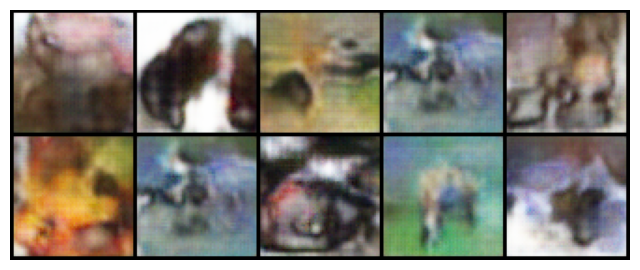

[35/70]	Loss_D: -0.0000	Loss_G: 0.0004	Fretchet_Distance: 193.6555


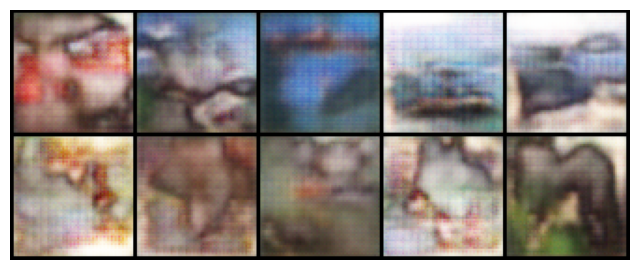

[40/70]	Loss_D: -0.0000	Loss_G: 0.0041	Fretchet_Distance: 189.2050


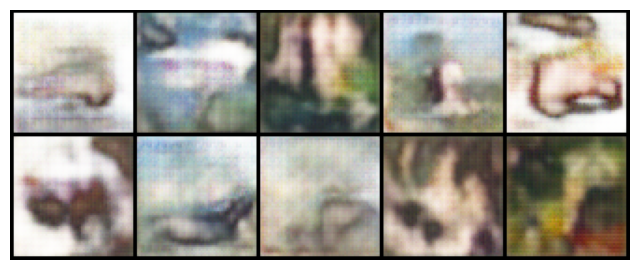

[45/70]	Loss_D: -0.0000	Loss_G: 0.0004	Fretchet_Distance: 193.1273


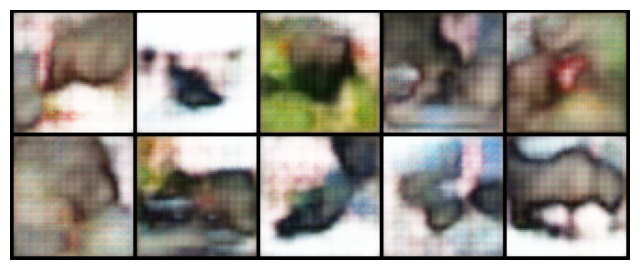

[50/70]	Loss_D: 0.0021	Loss_G: 0.0018	Fretchet_Distance: 198.3854


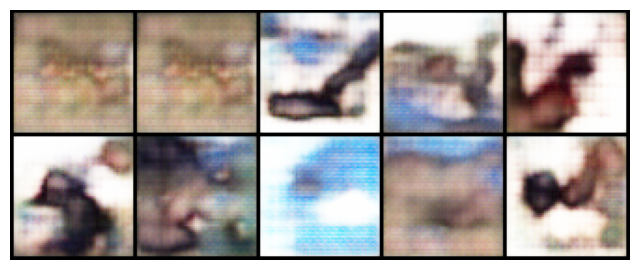

[55/70]	Loss_D: 0.0007	Loss_G: 0.0001	Fretchet_Distance: 190.3099


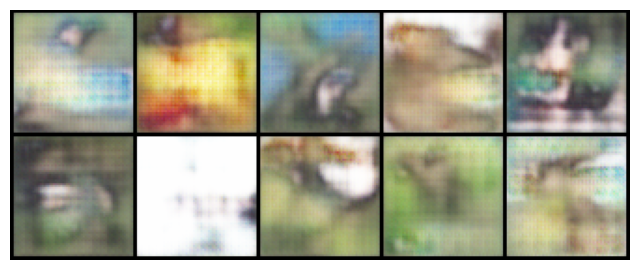

[60/70]	Loss_D: -0.0001	Loss_G: 0.0032	Fretchet_Distance: 195.2206


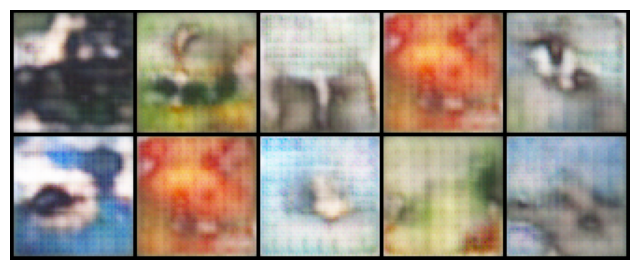

[65/70]	Loss_D: -0.0002	Loss_G: 0.0050	Fretchet_Distance: 200.3818


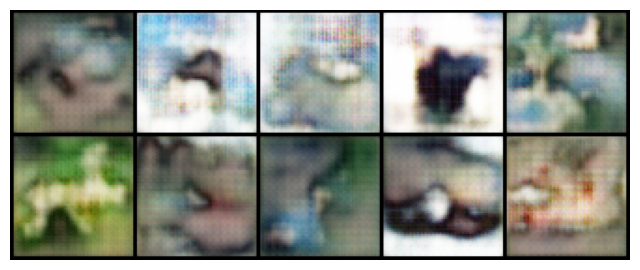

[70/70]	Loss_D: 0.0010	Loss_G: 0.0008	Fretchet_Distance: 202.1804


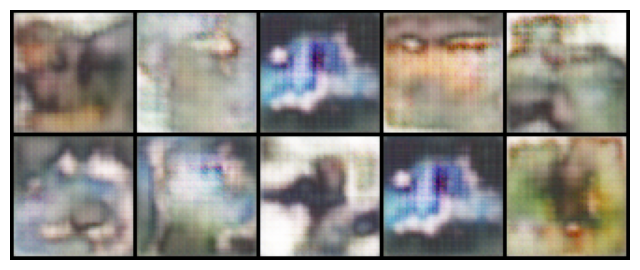

In [21]:
img_list = []
G_losses = []
D_losses = []
fid_list = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()

        # Get real data and prepare labels
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        real_cpu = real_cpu * 0.9 + 0.1 * torch.randn_like(real_cpu)  # Add noise for robustness
        
        # Clip Discriminator parameters for WGAN
        for param in netD.parameters():
            param.data.clamp_(-clamp_num, clamp_num)

        # Pass real images through the Discriminator
        output_real = netD(real_cpu).view(-1)
        errD_real = -output_real.mean()
        D_x = output_real.mean().item()

        # Generate fake data with the Generator
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake = fake * 0.9 + 0.1 * torch.randn_like(fake)  
        output_fake = netD(fake.detach()).view(-1)
        errD_fake = output_fake.mean()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        netG.zero_grad()

        # Train Generator to maximize the Discriminator's response
        output_fake_for_G = netD(fake).view(-1)
        errG = -output_fake_for_G.mean()
        D_G_z2 = output_fake_for_G.mean().item()
        errG.backward()
        optimizerG.step()
        if iters % 500 == 0 or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))

        iters += 1

    # Track losses and metrics
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    fretchet_dist = calculate_fretchet(real_cpu, fake, model)
    fid_list.append(fretchet_dist)

    # Display progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f' %
              (epoch + 1, num_epochs, errD.item(), errG.item(), fretchet_dist))
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        selected_images = fake_display[torch.randint(len(fake_display), (10,))]
        pictures = vutils.make_grid(selected_images, nrow=5, padding=2, normalize=True)
        plt.imshow(np.transpose(pictures, (1, 2, 0)))
        plt.show()


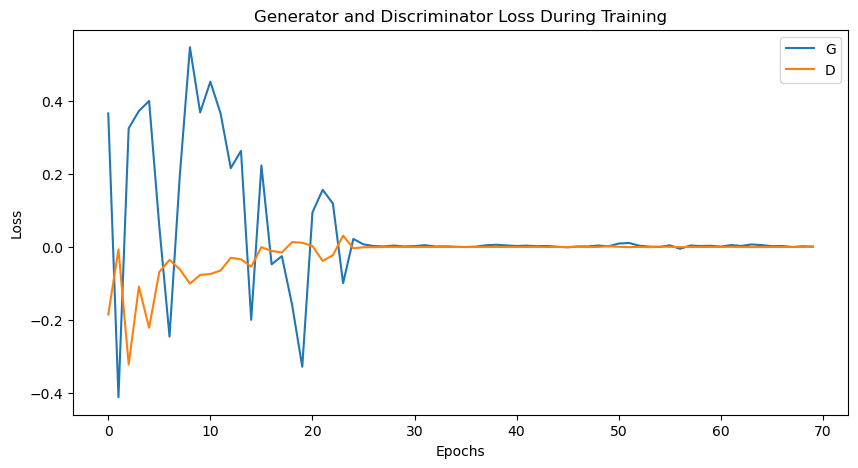

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

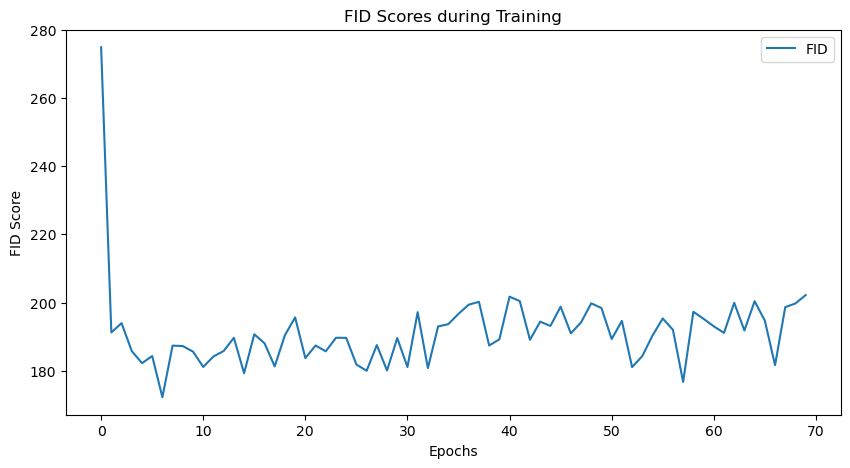

In [27]:
plt.figure(figsize=(10,5))
plt.title("FID Scores during Training")
plt.plot(fid_list,label="FID")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.show()

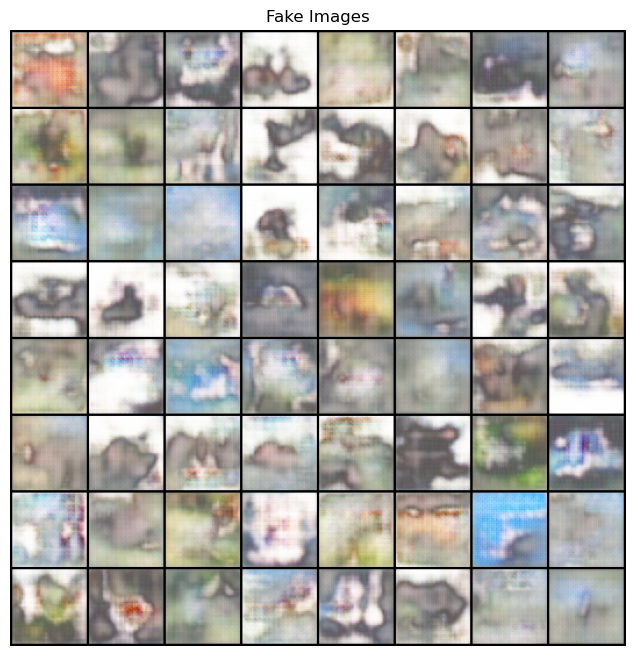

In [28]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()